In [2]:
import numpy as np       # import numpy zum Matrizen und Vektor rechnen
import tensorflow as tf  # keras zu tensorflow importieren
import cv2               # import opencv
import matplotlib.pyplot as plt # plt ermöglicht Graphen und Bilder auszugeben

#from tensorflow.python.util import deprecation
#from tensorflow.keras import backend
#from tensorflow.keras.applications.resnet50 import preprocess_input
# deprecation._PRINT_DEPRECATION_WARNINGS = False

from tensorflow.keras.models import Sequential # import Sequentielles Keras Modell
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten # import von verschiedenen Layerarten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam # Optimierer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model  # von keras datasets, layers und modelle importieren
from IPython.display import Image # um Bilder darzustellen
from tensorflow.keras.applications import imagenet_utils # 
print("import done")

physical_devices = tf.config.experimental.list_physical_devices('GPU') # zum auslesen ob eine GPU verbaut ist
print("Num GPUs Available: ", len(physical_devices)) # Anzahl GPUs ausgeben
tf.config.experimental.set_memory_growth(physical_devices[0], True) # Tensorflow auf diese GPU einstellen

import done
Num GPUs Available:  1


In [3]:
model = Sequential()  # Sequentielles Modell, when 1 Input und 1 Output

# ersten 2 Conv Layer. Erster Conv Layer bekommt die Bildgröße
model.add(Conv2D(input_shape = (224, 224, 3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))  # pooling mit filtergröße 2x2 und strides (x+2,y+2)

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2))) 

model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

# Dense und Softmax Layer
model.add(Flatten())
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

opt = Adam(lr = 0.001) # optimierer Learning Rate = 0.001 , zwischen 0.01 - 0.0001 -> kleinere Schritte um zum minimalen Loss zu kommen
model.compile(optimizer = opt, loss= tf.keras.losses.categorical_crossentropy, metrics = ['accuracy']) # Accuracy berechnet wie of Vorhersage = Label
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [9]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="cats_and_dogs_filtered/train",target_size=(224,224),classes=['dogs', 'cats'],class_mode='binary') # class_mode default: categorical
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="cats_and_dogs_filtered/validation", target_size=(224,224),classes=['dogs', 'cats'],class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
traindata.class_indices

{'dogs': 0, 'cats': 1}

In [11]:
testdata.class_indices

{'dogs': 0, 'cats': 1}

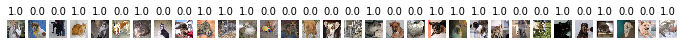

In [21]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
imgs, labels = next(traindata)
plots(imgs, titles=labels)

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("vgg16weights.h5",
                                                #monitor="val_loss",
                                                monitor="val_accuracy",
                                                verbose = 1,
                                                #save_best_only = False,
                                                save_best_only = True,
                                                save_weights_only = False,
                                                mode= "auto",
                                                save_freq= "epoch",
                                                options=None)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      #patience=40,
                      patience=20,
                      verbose=1,
                      mode='auto')

hist = model.fit(x=traindata,
                          steps_per_epoch = 100,
                          epochs = 100,
                          validation_data = testdata,
                          validation_steps = 1,
                          callbacks = [checkpoint,early])

model.save_weights('modelweight.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 1 steps
Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 0.6985 - accuracy: 0.5102
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to vgg16weights.h5
50/50 [==============================] - 22s 446ms/step - loss: 0.6958 - accuracy: 0.5200 - val_loss: 0.5632 - val_accuracy: 1.0000
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.3918
Epoch 00002: val_accuracy did not improve from 1.00000
50/50 [==============================] - 13s 256ms/step - loss: 0.6888 - accuracy: 0.4040 - val_loss: 0.5632 - val_accuracy: 1.0000
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.5306
Epoch 00003: val_accuracy did not improve from 1.00000
50/50 [==============================] - 13s 259ms/step - loss: 0.7044 - accuracy: 0.5400 - val_loss: 0.5632 - val_accuracy: 1.0000
Epoch 4/100
49/50 [==========

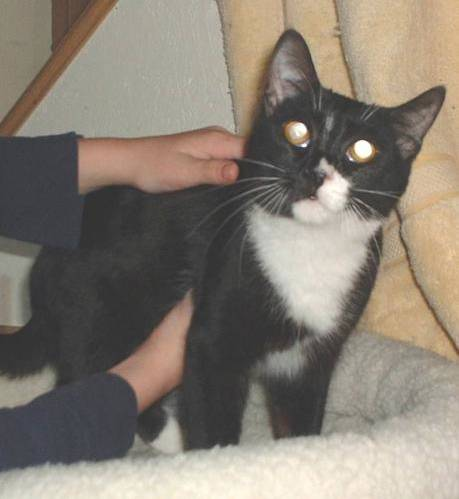

[[('n02124075', 'Egyptian_cat', 0.48184782),
  ('n04265275', 'space_heater', 0.07596425),
  ('n03887697', 'paper_towel', 0.06203251),
  ('n02883205', 'bow_tie', 0.050314907),
  ('n04493381', 'tub', 0.03254755)]]

In [22]:
imagenet = tf.keras.applications.mobilenet.MobileNet()

def prepare_image(file):
    img_path = 'cats_and_dogs_filtered/validation'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)


display(Image(filename='cats_and_dogs_filtered/validation/cats/cat.2000.jpg', width=224,height=224))

preprocessed_image = prepare_image('/cats/cat.2000.jpg')
predictions = imagenet.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

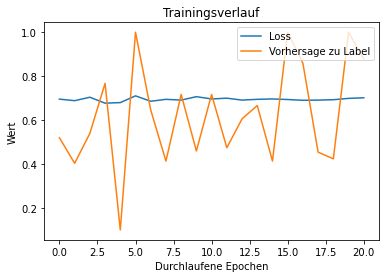

In [15]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['accuracy'], label='Vorhersage zu Label')
plt.title('Trainingsverlauf')
plt.ylabel('Wert')
plt.xlabel('Durchlaufene Epochen')
plt.legend(loc="upper right")
plt.show()

cat


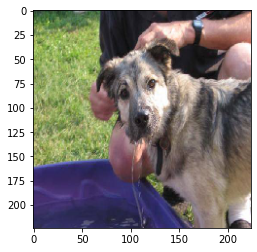

In [25]:
#img = image.load_img("Katze.jpg",target_size=(224,224))
#img = image.load_img("cats_and_dogs_filtered/validation/cats/cat.2000.jpg",target_size=(224,224))
img = image.load_img("cats_and_dogs_filtered/validation/dogs/dog.2004.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model("vgg16weights.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')